In [1]:
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
with open("../tracking_stubs/ball_detection.pkl","rb") as f:
    ball_positions = pkl.load(f)


In [17]:
ball_detections= [x.get(1,[]) for x in ball_positions]

#change it to a pandas data frame to use the interpolate functions
ball_detections_df = pd.DataFrame(ball_detections,columns=['x1','y1','x2','y2'])
        
ball_detections_df = ball_detections_df.interpolate()
        #filling the first frames 
ball_detections_df = ball_detections_df.bfill()
        
ball_detections = [{1:x} for x in ball_detections_df.to_numpy().tolist()]


In [19]:
ball_detections_df

,x1,y1,x2,y2
0,822.754211,687.889893,836.956970,703.234314
1,822.754211,687.889893,836.956970,703.234314
2,822.754211,687.889893,836.956970,703.234314
3,822.754211,687.889893,836.956970,703.234314
4,822.754211,687.889893,836.956970,703.234314
...,...,...,...,...
209,1188.568911,246.240005,1200.117065,258.504767
210,1184.881470,232.816147,1196.261353,244.988724
211,1184.068237,226.247955,1197.245728,241.382721
212,1180.170410,214.140472,1194.881470,229.481049


In [21]:
ball_detections_df['mean_y'] = (ball_detections_df["y1"] + ball_detections_df ["y2"])/2

In [27]:
ball_detections_df['mean_y'] = (ball_detections_df["y1"] + ball_detections_df ["y2"])/2
# Calculate the rolling mean of the 'mean_y' column with a window size of 5,
# requiring at least 1 value per window, and place the result in a new column 'mean_y_rolling_mean'.
# The window is not centered, meaning it uses the current and previous values for the calculation.
ball_detections_df['mean_y_rolling_mean'] = ball_detections_df['mean_y'].rolling(window=5, min_periods=1, center=False).mean()
ball_detections_df['delta_y'] = ball_detections_df['mid_y_rolling_mean'].diff()


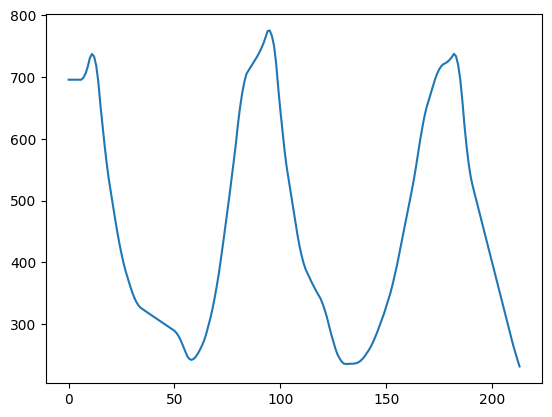

In [28]:
plt.plot(ball_detections_df['mid_y_rolling_mean'])

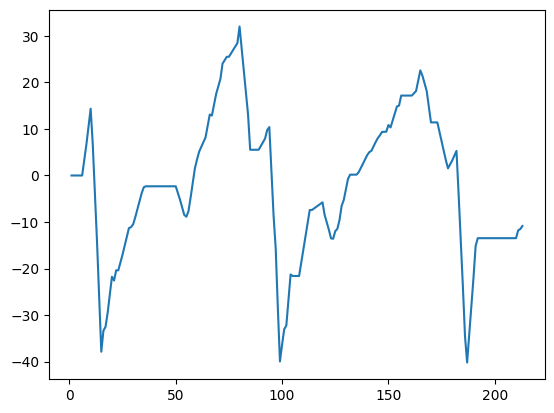

In [31]:
ball_detections_df['delta_y'] = ball_detections_df['mid_y_rolling_mean'].diff()
# plot mid_y_rolling_mean
plt.plot(ball_detections_df['delta_y'])

In [32]:
ball_detections_df['ball_hit']=0
minimum_change_frames_for_hit = 25
for i in range(1,len(ball_detections_df)- int(minimum_change_frames_for_hit*1.2) ):
    negative_position_change = ball_detections_df['delta_y'].iloc[i] >0 and ball_detections_df['delta_y'].iloc[i+1] <0
    positive_position_change = ball_detections_df['delta_y'].iloc[i] <0 and ball_detections_df['delta_y'].iloc[i+1] >0

    if negative_position_change or positive_position_change:
        change_count = 0 
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = ball_detections_df['delta_y'].iloc[i] >0 and ball_detections_df['delta_y'].iloc[change_frame] <0
            positive_position_change_following_frame = ball_detections_df['delta_y'].iloc[i] <0 and ball_detections_df['delta_y'].iloc[change_frame] >0

            if negative_position_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_position_change and positive_position_change_following_frame:
                change_count+=1
    
        if change_count>minimum_change_frames_for_hit-1:
            ball_detections_df['ball_hit'].iloc[i] = 1

frame_nums_with_ball_hits = ball_detections_df[ball_detections_df['ball_hit']==1].index.tolist()


C:\Users\salwa\AppData\Local\Temp\ipykernel_4828\3254137099.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ball_detections_df['ball_hit'].iloc[i] = 1
C:\Users\salwa\AppData\Local\Temp\ipykernel_4828\3254137099.py:19: SettingWithCopyWar

In [33]:
ball_detections_df[ball_detections_df['ball_hit']==1]


,x1,y1,x2,y2,mean_y,mid_y_rolling_mean,mean_y_rolling_mean,delta_y,ball_hit
11,777.972107,717.838806,796.685852,739.078491,728.458649,737.068301,737.068301,6.579309,1
58,926.006030,240.594699,939.068481,253.923105,247.258902,242.324698,242.324698,-1.596962,1
95,624.725311,749.244232,641.136383,766.280823,757.762527,775.167935,775.167935,0.889285,1
131,716.346527,229.184288,729.521179,242.902527,236.043407,235.683077,235.683077,-0.723661,1
182,1296.037109,740.427795,1314.294922,758.785583,749.606689,737.401254,737.401254,5.286462,1
